In [75]:
import numpy as np
import scipy
from scipy.special import gamma
import matplotlib.pyplot as plt
import colorcet as cc


# In unit circle


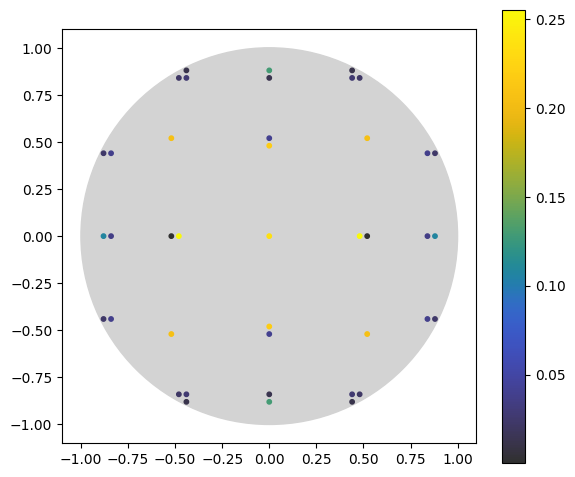

In [77]:
m = 10
M = 51
# Dirac measure
dirac = lambda X,x: int(x in X)

# Monomials and q(P^(j))
def ps(n):
    p , q= [] , []
    for i in range(n):
        for j in range(n-i):
            p.append((i , j))
            if j % 2 == 1 or i % 2 == 1:
                q.append(0)
            else:
                a_i , a_j = i , j
                b_i , b_j = (a_i + 1) / 2 , (a_j + 1) / 2
                q.append(1/(a_i+a_j+2)*gamma(b_i)*gamma(b_j)*2/gamma(b_i+b_j))
    return p , np.array(q,dtype=float)
P , b_eq = ps(m)

# Sample points with a small mesh size
_ = np.linspace(-1,1,M)
sx , sy = np.meshgrid(_ , _)
legal = (sx**2 + sy**2 <=1)
sx = sx[legal].flatten()
sy = sy[legal].flatten()

# Sensitivity function
r = lambda x , y: x ** m + y ** m
# Coefficients of \mu(r)
c = r(sx , sy)
# Equality constraint
A_eq = np.array([sx ** i * sy ** j for i,j in P])
alpha = scipy.optimize.linprog(c , A_eq=A_eq , b_eq=b_eq , bounds=(0,np.inf)).x
nozero = alpha != 0
nonzero_a = alpha[nozero]
nonzero_x , nonzero_y= sx[nozero] , sy[nozero]
plt.figure(figsize=(6, 5))
plt.gca().add_artist(plt.Circle((0, 0), 1, color='lightgray'))
plt.scatter(nonzero_x,nonzero_y , 10, nonzero_a, cmap=cc.cm.gouldian,
zorder=1)
plt.colorbar()
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()

# In squre

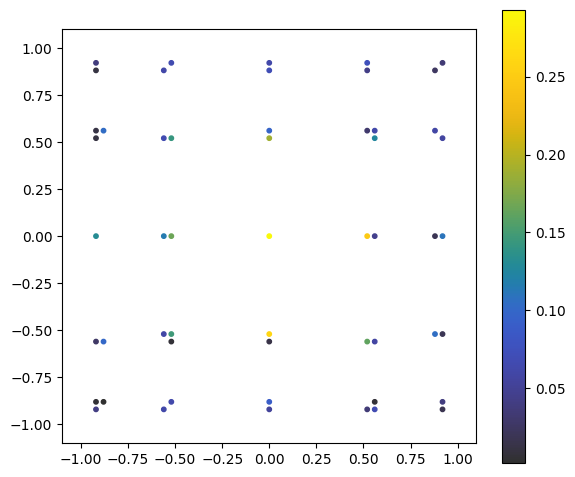

In [80]:
m = 10
M = 51
# Dirac measure
dirac = lambda X,x: int(x in X)

# Monomials and q(P^(j))
def ps(n):
    p , q= [] , []
    for i in range(n):
        for j in range(n-i):
            p.append((i , j))
            if j % 2 == 1 or i % 2 == 1:
                q.append(0)
            else:
                a_i , a_j = i , j
                b_i , b_j = (a_i + 1) / 2 , (a_j + 1) / 2
                q.append(4 / ((j + 1) * (i + 1)))
    return p , np.array(q,dtype=float)
P , b_eq = ps(m)

# Sample points with a small mesh size
_ = np.linspace(-1,1,M)
sx , sy = np.meshgrid(_ , _)
sx = sx.flatten()
sy = sy.flatten()

# Sensitivity function
r = lambda x , y: x ** m + y ** m
# Coefficients of \mu(r)
c = r(sx , sy)
# Equality constraint
A_eq = np.array([sx ** i * sy ** j for i,j in P])
alpha = scipy.optimize.linprog(c , A_eq=A_eq , b_eq=b_eq , bounds=(0,np.inf)).x
nozero = alpha != 0
nonzero_a = alpha[nozero]
nonzero_x , nonzero_y= sx[nozero] , sy[nozero]
plt.figure(figsize=(6, 5))
plt.scatter(nonzero_x,nonzero_y , 10, nonzero_a, cmap=cc.cm.gouldian,
zorder=1)
plt.colorbar()
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()

In [102]:
from sklearn.cluster import KMeans
n_c = int(m*(m+1)/2//2)
X = np.array([[nonzero_x[i] , nonzero_y[i]] for i in range(len(nonzero_x))])
kmeans = KMeans(n_clusters=n_c ).fit(X)
x_ = []
a_ = []

for label in range(n_c):
    group = kmeans.labels_ == label
    points = X[group]
    weights = nonzero_a[group]
    sum_w = weights.sum()
    x_.append((points.T@weights) / (sum_w))
    a_.append(sum_w)

x_ = np.array(x_)
a_ = np.array(a_)